# What Dog App

## Dog Breed Identifer using Convolutional Neural Networks


---
### Why We're Here 

In this notebook an algorithm has been developed to be ready for deployment as part of a mobile or web app.  At the end of this project, the code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of the finished project.

![Sample Dog Output](images/sample_dog_output.png)

In this project a series of models have been pieced together to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure as no perfect algorithm exists so any imperfect solutions are fun user experiences!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


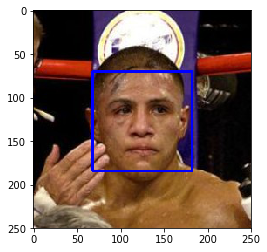

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [5]:
#new cell
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

In [6]:
print(human_files_short[:5])

['lfw/John_Eder/John_Eder_0001.jpg'
 'lfw/Nicole_Kidman/Nicole_Kidman_0002.jpg'
 'lfw/Colin_Powell/Colin_Powell_0201.jpg'
 'lfw/Fernando_Vargas/Fernando_Vargas_0001.jpg'
 'lfw/Mark_Heller/Mark_Heller_0001.jpg']


In [7]:
face_detector(human_files_short[5])

True

### Assess data-the Human Face Detector

Testing the performance of the `face_detector` function to ascertain:  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 



In [8]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]


## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

In [9]:
x = 0
#hfaces = face_detector(human_files_short[x])

hfaces_list =[]

for i in range(len(human_files_short)):
    hfaces = face_detector(human_files_short[x])
    hfaces_list.append(hfaces)
    x = x + 1


true_faces= hfaces_list.count(True)
false_faces = hfaces_list.count(False)
total_faces = true_faces + false_faces

print(true_faces)
print(false_faces)
print(total_faces)

print(str(true_faces/total_faces * 100)+ "%")


98
2
100
98.0%


In [10]:
#THE SOLUTION

x = 0

dfaces_list =[]

for i in range(len(dog_files_short)):
    dfaces = face_detector(dog_files_short[x])
    dfaces_list.append(dfaces)
    x = x + 1



true_faces= dfaces_list.count(True)
false_faces = dfaces_list.count(False)
total_faces = true_faces + false_faces

print(true_faces)
print(false_faces)
print(total_faces)

print(str(true_faces/total_faces * 100)+ "%")

11
89
100
11.0%


---
<a id='step2'></a>
## Step 2: Detect Dogs

We use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [12]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs requires a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [13]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [14]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

Testing the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?



In [16]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

x = 0

dog_hum_list =[]

for i in range(len(human_files_short)):
    dogdet = dog_detector(human_files_short[x])
    dog_hum_list.append(dogdet)
    x = x + 1
#print (dog_hum_list)

true_faces= dog_hum_list.count(True)
false_faces = dog_hum_list.count(False)
total_faces = true_faces + false_faces

print(true_faces)
print(false_faces)
print(total_faces)

print(str(true_faces/total_faces * 100)+ "%")

2
98
100
2.0%


In [17]:
print (dog_hum_list)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [18]:
print(dog_hum_list.index(True))

54


In [19]:
print(dog_hum_list[54])
human_files_short[54]

True


'lfw/Anders_Ebbeson/Anders_Ebbeson_0001.jpg'

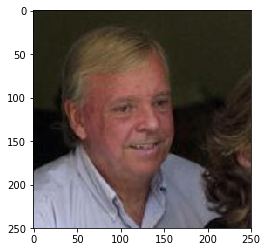

In [20]:
img3 = cv2.imread(human_files_short[54])
cv_rgb3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb3)
plt.show()

In [21]:
print(dog_hum_list[55:].index(True))

31


In [22]:
print(dog_hum_list[86])
human_files_short[86]

True


'lfw/Jake_Gyllenhaal/Jake_Gyllenhaal_0004.jpg'

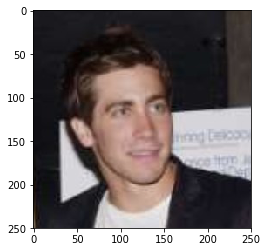

In [23]:
img3 = cv2.imread(human_files_short[86])
cv_rgb3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb3)
plt.show()

In [24]:
print(dog_hum_list[55:].index(True))

31


In [25]:
x = 0

dog_dog_list =[]

for i in range(len(dog_files_short)):
    dogdet = dog_detector(dog_files_short[x])
    dog_dog_list.append(dogdet)
    x = x + 1
#print (dog_hum_list)

true_faces= dog_dog_list.count(True)
false_faces = dog_dog_list.count(False)
total_faces = true_faces + false_faces

print(true_faces)
print(false_faces)
print(total_faces)

print(str(true_faces/total_faces * 100)+ "%")

100
0
100
100.0%


---
<a id='step3'></a>
## Step 3: Creating a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [26]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 137.76it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Below is a summary of the layers to the model:
    
        


In [27]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### Defining architecture.

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
#model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [28]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [29]:
### Do not run again to hold results 
from keras.callbacks import ModelCheckpoint  

### Specify the number of epochs to train the model.

epochs = 5


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 24s - loss: 4.8835 - acc: 0.0099 - val_loss: 4.8709 - val_acc: 0.0132
Epoch 2/5
6680/6680 [==============================] - 23s - loss: 4.8596 - acc: 0.0130 - val_loss: 4.8341 - val_acc: 0.0204
Epoch 3/5
6680/6680 [==============================] - 23s - loss: 4.8020 - acc: 0.0184 - val_loss: 4.7797 - val_acc: 0.0156
Epoch 4/5
6680/6680 [==============================] - 23s - loss: 4.7526 - acc: 0.0187 - val_loss: 4.7338 - val_acc: 0.0204
Epoch 5/5
6680/6680 [==============================] - 23s - loss: 4.7135 - acc: 0.0216 - val_loss: 4.8126 - val_acc: 0.0204


In [30]:
from keras.callbacks import ModelCheckpoint  

### Specify number of epochs to train the model.

epochs = 5


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 23s - loss: 4.6760 - acc: 0.0223 - val_loss: 4.6923 - val_acc: 0.0287
Epoch 2/5
6680/6680 [==============================] - 23s - loss: 4.6427 - acc: 0.0286 - val_loss: 4.6386 - val_acc: 0.0263
Epoch 3/5
6680/6680 [==============================] - 23s - loss: 4.6091 - acc: 0.0302 - val_loss: 4.6210 - val_acc: 0.0311
Epoch 4/5
6680/6680 [==============================] - 23s - loss: 4.5766 - acc: 0.0338 - val_loss: 4.5986 - val_acc: 0.0335
Epoch 5/5
6680/6680 [==============================] - 23s - loss: 4.5418 - acc: 0.0335 - val_loss: 4.5530 - val_acc: 0.0347


### Load the Model with the Best Validation Loss

In [31]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Testing the model on the test dataset of dog images, aiming for test accuracy is greater than 1%.

In [32]:
# getting index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.4258%


In [33]:
###With dropout .3
# getting index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.4258%


In [34]:
###With extra dense layer 500 relu & dropout .4 No impact!!!
# getting index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.4258%


---
<a id='step4'></a>
## Step 4: Using CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, a CNN is trained using transfer learning.  

### Obtain Bottleneck Features

In [35]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  A global average pooling layer is added with a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [36]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [37]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [38]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.2286 - acc: 0.1260 - val_loss: 10.8159 - val_acc: 0.2132
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.0880 - acc: 0.2888 - val_loss: 10.0225 - val_acc: 0.2922
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.5451 - acc: 0.3503 - val_loss: 9.6412 - val_acc: 0.3305
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.2204 - acc: 0.3873 - val_loss: 9.5102 - val_acc: 0.3353
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.0334 - acc: 0.4070 - val_loss: 9.3577 - val_acc: 0.3497
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 8.7634 - acc: 0.4280 - val_loss: 9.1636 - val_acc: 0.3593
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.6661 - acc: 0.4415 - val_loss: 9.1061 - val_acc: 0.3749
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.5888 

### Load the Model with the Best Validation Loss

In [39]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Using CNN to test how well it identifies breed within our test dataset of dog images.

In [40]:
# getting index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# reporting test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 44.8565%


### Predict Dog Breed with the Model

In [41]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Creating a CNN to Classify Dog Breeds (using Transfer Learning)

Using transfer learning to create a CNN that can identifies dog breed from images, aiming to attain 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [42]:
### Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Summarizing the layers of model


In [43]:
### Defining architecture.

Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [44]:
### Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Training model in the code cell below, using model checkpointing to save the model that attains the best validation loss.  



In [45]:
### Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 1.6426 - acc: 0.5961 - val_loss: 0.8360 - val_acc: 0.7473
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 0.4370 - acc: 0.8633 - val_loss: 0.6568 - val_acc: 0.7880
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 0.2595 - acc: 0.9160 - val_loss: 0.6794 - val_acc: 0.8012
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 0.1734 - acc: 0.9452 - val_loss: 0.6919 - val_acc: 0.7964
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 0.1238 - acc: 0.9614 - val_loss: 0.6815 - val_acc: 0.8096
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 0.0840 - acc: 0.9723 - val_loss: 0.6772 - val_acc: 0.8096
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 0.0634 - acc: 0.9804 - val_loss: 0.6926 - val_acc: 0.8084
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 0.0465 - ac

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [46]:
### Loading the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Testing model on the test dataset of dog images, aiming for test accuracy greater than 60%.

In [47]:
### Calculating classification accuracy on the test dataset.
# getting index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.2201%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by model.  



In [48]:
### Function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [49]:
Resnet50_predict_breed(dog_files_short[5])

'English_springer_spaniel'

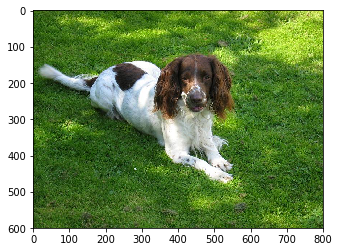

In [50]:
img4 = cv2.imread(dog_files_short[5])
cv_rgb4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb4)
plt.show()

---
<a id='step6'></a>
## Step 6: What Dog App Algorithm

Algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


As per example below:


![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [79]:
new_humans = np.array(glob("faces/*"))

In [80]:
print(new_humans)

['faces/download18.jpg' 'faces/download14.jpg' 'faces/download15.jpg'
 'faces/download20.jpg' 'faces/download11.jpg' 'faces/download5.jpg'
 'faces/download17.jpg' 'faces/download3.jpg' 'faces/download8.jpg'
 'faces/download23.jpg' 'faces/download19.jpg' 'faces/download21.jpg'
 'faces/download22.jpg' 'faces/download10.jpg' 'faces/download24.jpg'
 'faces/download7.jpg' 'faces/download9.jpg' 'faces/download2.jpg'
 'faces/download1.jpg' 'faces/download6.jpg' 'faces/download16.jpg'
 'faces/download4.jpg' 'faces/download13.jpg' 'faces/download25.jpg'
 'faces/download12.jpg']


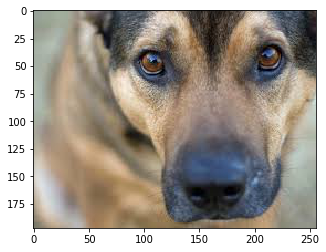

In [53]:
img_input2 = new_humans[10]
img5 = cv2.imread(img_input2)
cv_rgb5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb5)
plt.show()

In [54]:
print('There are %d total human images.' % len(new_humans))

There are 26 total human images.


Number of faces detected: 0


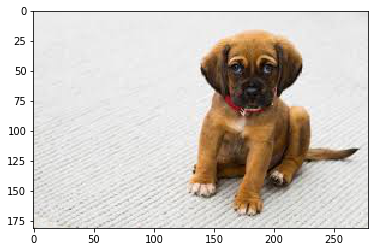

In [55]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(new_humans[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [56]:
y_hat = Resnet50_predict_breed(new_humans[3])
print(y_hat)

Leonberger


This is a Human
Hello Human!!!


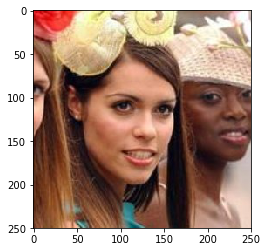

You look like a English_toy_spaniel?!


In [57]:
### The algorithm.

### 1) Load Image

img_input = human_files_short[10]

### 2) Detect if human image

if dog_detector(img_input) == True:
    print("This is a Dog")
    print("Hello Dog!!!")

elif face_detector(img_input) == True:
    print("This is a Human")
    print("Hello Human!!!")
    
else:
    print("This is NO Dog nor Human, arraghhhh... There's an ERROR!!!")
    print("Hello, What are YOU!!!")



### 3) Display Image

img5 = cv2.imread(img_input)
cv_rgb5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb5)
plt.show()

### 4) Predict type of Dog Type

label = "You look like a "
prediction = Resnet50_predict_breed(img_input)
print(label + prediction +"?!")

---
<a id='step7'></a>
## Step 7: Test the Algorithm

In this section, we'll take the new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If its a dog, does it predict the dog's breed accurately?  If it's a cat, does it mistakenly think the cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Testing algorithm on selection of mixed images

This is a Dog
Hello Dog!!!


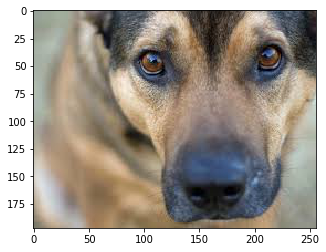

You look like a German_shepherd_dog?!


In [59]:
## Executing the algorithm from Step 6 on
## mixed images

### 1) Load Image

img_input = new_humans[10]

### 2) Detect if human image

if dog_detector(img_input) == True:
    print("This is a Dog")
    print("Hello Dog!!!")

elif face_detector(img_input) == True:
    print("This is a Human")
    print("Hello Human!!!")
    
else:
    print("This is NO Dog nor Human, arraghhhh... There's an ERROR!!!")
    print("Hello, What are YOU!!!")



### 3) Display Image

img5 = cv2.imread(img_input)
cv_rgb5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb5)
plt.show()

### 4) Predict type of Dog Type

label = "You look like a "
prediction = Resnet50_predict_breed(img_input)
print(label + prediction +"?!")

This is NO Dog nor Human, arraghhhh... There's an ERROR!!!
Hello, What are YOU!!!


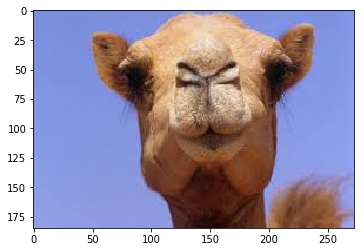

You look like a Chinese_shar-pei?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is NO Dog nor Human, arraghhhh... There's an ERROR!!!
Hello, What are YOU!!!


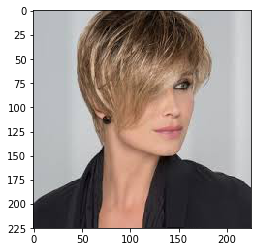

You look like a Lowchen?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


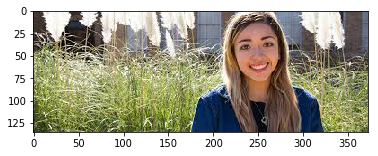

You look like a English_toy_spaniel?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Dog
Hello Dog!!!


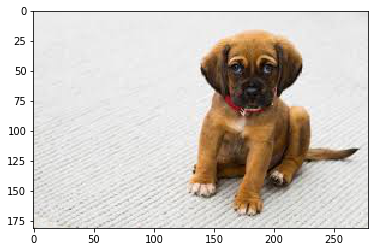

You look like a Leonberger?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


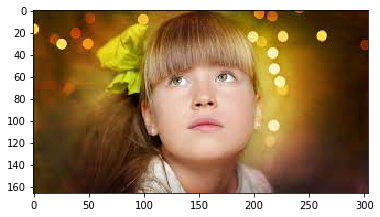

You look like a English_toy_spaniel?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


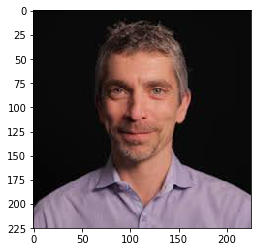

You look like a Bull_terrier?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is NO Dog nor Human, arraghhhh... There's an ERROR!!!
Hello, What are YOU!!!


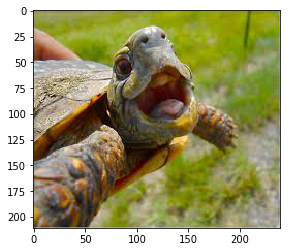

You look like a Basset_hound?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


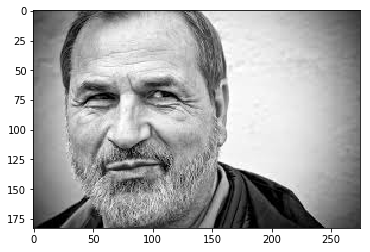

You look like a English_toy_spaniel?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


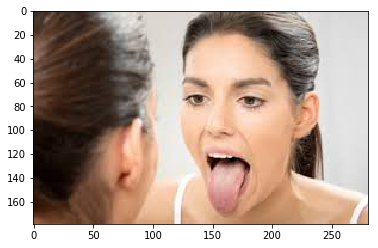

You look like a Yorkshire_terrier?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Dog
Hello Dog!!!


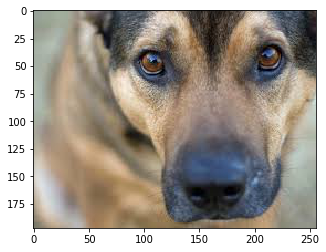

You look like a German_shepherd_dog?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is NO Dog nor Human, arraghhhh... There's an ERROR!!!
Hello, What are YOU!!!


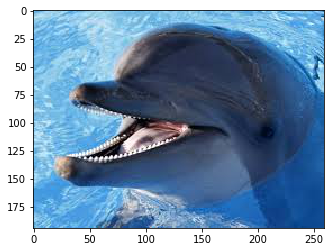

You look like a Curly-coated_retriever?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Dog
Hello Dog!!!


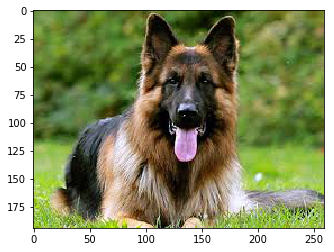

You look like a Belgian_tervuren?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Dog
Hello Dog!!!


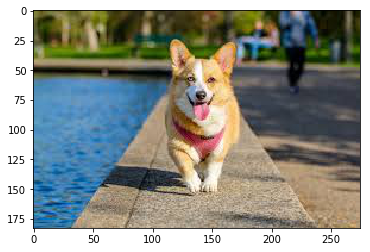

You look like a Cardigan_welsh_corgi?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


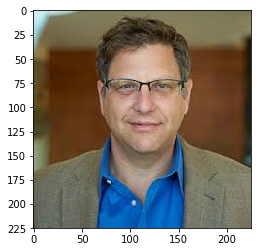

You look like a Xoloitzcuintli?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Dog
Hello Dog!!!


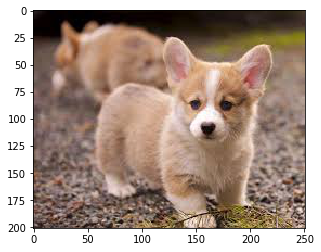

You look like a Pembroke_welsh_corgi?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


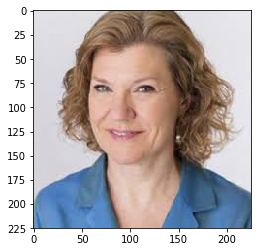

You look like a Chesapeake_bay_retriever?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


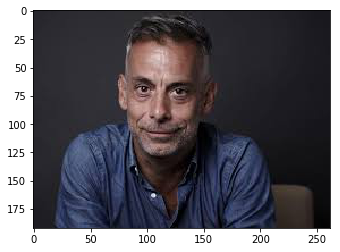

You look like a Bullmastiff?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


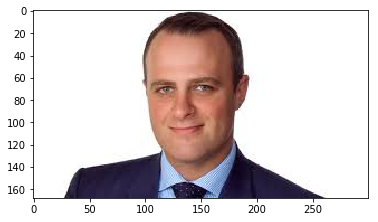

You look like a Beagle?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


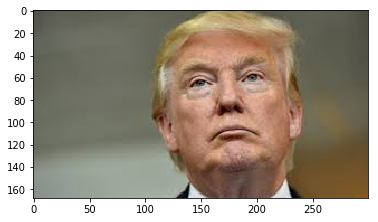

You look like a Bullmastiff?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


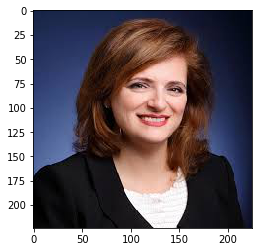

You look like a Afghan_hound?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is NO Dog nor Human, arraghhhh... There's an ERROR!!!
Hello, What are YOU!!!


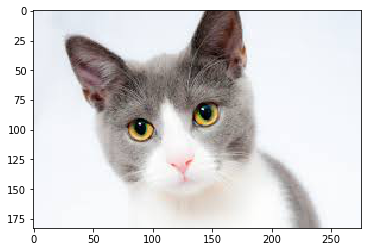

You look like a Chihuahua?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


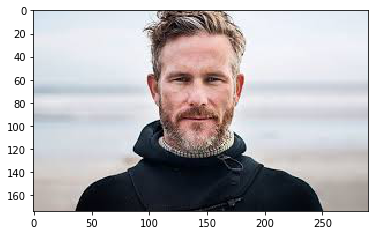

You look like a Doberman_pinscher?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


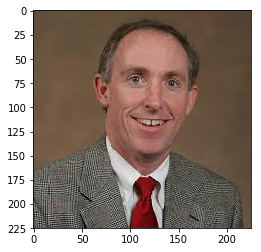

You look like a English_springer_spaniel?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Dog
Hello Dog!!!


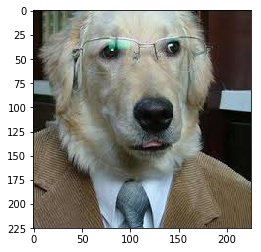

You look like a Golden_retriever?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
This is a Human
Hello Human!!!


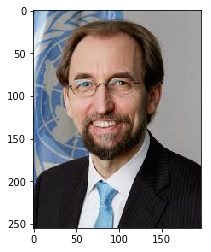

You look like a English_toy_spaniel?!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [81]:
y = 0

for i in range(len(new_humans)):
    img_input = new_humans[y]
    if dog_detector(img_input) == True:
        print("This is a Dog")
        print("Hello Dog!!!")

    elif face_detector(img_input) == True:
        print("This is a Human")
        print("Hello Human!!!")
    
    else:
        print("This is NO Dog nor Human, arraghhhh... There's an ERROR!!!")
        print("Hello, What are YOU!!!")
    
    img5 = cv2.imread(img_input)
    cv_rgb5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb5)
    plt.show()


    label = "You look like a "
    prediction = Resnet50_predict_breed(img_input)
    print(label + prediction +"?!")
    
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Next Image~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    y = y + 1
    
